# EVALUATION OF ESTIMATIONS

In [1]:
from iplane.interpolator import Interpolator  # type: ignore
from iplane.random_mixture_collection import PCollectionMixture, DCollectionMixture  # type: ignore
from iplane.random_mixture import RandomMixture  # type: ignore
from iplane.random_empirical import RandomEmpirical  # type: ignore
import iplane.constants as cn  # type: ignore

from collections import namedtuple
from matplotlib import pyplot as plt  # type: ignore
import pandas as pd
import numpy as np
from scipy.stats import norm, multivariate_normal # type: ignore

# Accuracy of Empirical Distributions

The accuracy of an empirical estimation depends on :
1. Number of samples used to construct the empirical distribution
2. Number of dimensions of the variate
3. How samples are selected to assess accuracy
4. For a guassian, covariance matrix

In [47]:
EvaluationResult = namedtuple("EvaluationResult",
        ["num_sample", "num_dimension", "variance", 
         "covariance", "mean_absolute_error", "fraction_evaluated", "sampling_std"])
def evaluateEmpirical(num_sample:int=100,
                      num_dimension:int=2,
                      variance:float=4,
                      covariance:float=0,
                      sampling_std:float=3,
                     ) -> EvaluationResult:
    # Constants
    NUM_ITERATION = 100
    # Initializations
    mean_arr = np.repeat(0, num_dimension)
    covariance_arr = np.repeat(covariance, num_dimension*num_dimension).reshape(num_dimension, num_dimension)
    np.fill_diagonal(covariance_arr, variance)
    weight_arr = np.array([1.0])
    pcollection = PCollectionMixture(
        mean_arr=np.array([mean_arr]),
        covariance_arr=np.array([covariance_arr]),
        weight_arr=weight_arr,
    )
    random_mixture = RandomMixture()
    random_empirical = RandomEmpirical()
    sample_arr = random_mixture.generateSample(pcollection, num_sample=num_sample)
    _ = random_empirical.estimatePCollection(sample_arr)
    cdf = random_empirical.makeCDF(sample_arr)
    variate_arr = cdf.variate_arr
    cdf_arr = cdf.cdf_arr
    #
    interpolator = Interpolator( variate_arr=variate_arr, sample_arr=cdf_arr,
            is_normalize=True, max_distance=1, size_interpolation_set=5)
    errors:list = []
    avg_errors:list = []
    results:list = []
    probabilities:list = []
    for _ in range(NUM_ITERATION):
        point = np.random.uniform(-sampling_std, sampling_std, (num_dimension,))
        if not interpolator.isWithinRange(point):
            continue
        if num_dimension == 1:
            probability = norm.cdf(point, 0, scale=variance**0.5)
        else:
            probability = multivariate_normal.cdf(point, mean=mean_arr, cov=covariance_arr)  # type: ignore
        result = interpolator.predict(point)
        if np.isnan(result[0]):
            continue
        results.append(result[0])
        probabilities.append(probability)
        errors.append(abs(probability - result[0]))
        avg_errors.append(probability - result[0])
    evaluation_result = EvaluationResult(
        num_sample=num_sample, num_dimension=num_dimension, variance=variance,
        mean_absolute_error=np.mean(errors),
        fraction_evaluated=len(errors)/NUM_ITERATION,
        covariance=covariance,
        sampling_std=sampling_std,
    )
    return evaluation_result

# Tests
evaluateEmpirical(num_dimension=5, num_sample=100, sampling_std=1, variance=1)

EvaluationResult(num_sample=100, num_dimension=5, variance=1, covariance=0, mean_absolute_error=np.float64(0.013598213469307745), fraction_evaluated=0.91, sampling_std=1)

Evaluations
1. Univariate, variance = 1. Heatmap with x,y = sample size, sampline_std. Color is frac succes, mean asolute error
2. Do the same for multivariates: 2,4, 8, 16

# Empirical density estimation

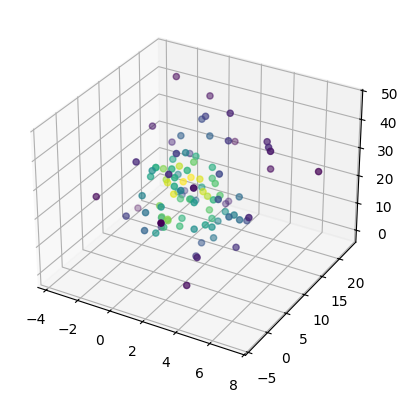

In [52]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

mu=np.array([1,10,20])
sigma=np.matrix([[4,10,0],[10,25,0],[0,0,100]])
sigma=np.matrix([[4,1,0],[1,25,0],[0,0,100]])
data=np.random.multivariate_normal(mu,sigma,100)
values = data.T

kde = stats.gaussian_kde(values)
density = kde(values)

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
x, y, z = values
ax.scatter(x, y, z, c=density)
plt.show()

Generated 1000 samples from a bivariate normal distribution.
Mean of generated X: -0.03, Y: -0.06
Covariance matrix of generated data:
[[0.94261404 0.66567039]
 [0.66567039 1.48975895]]

Gaussian KDE object created.
KDE bandwidth: 0.3162


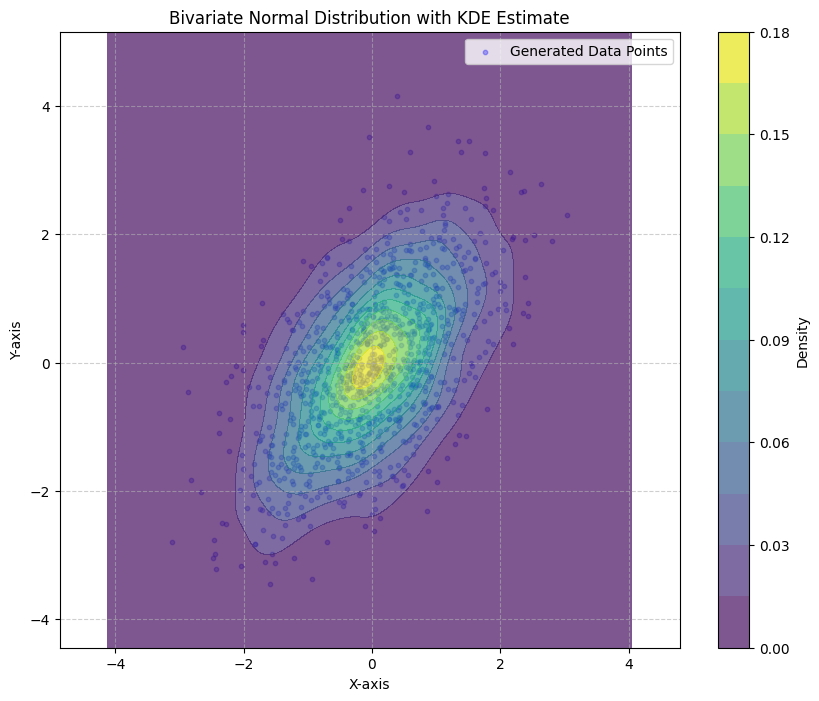


Visualization complete. The contours represent the estimated density.

Integrated density over the entire domain using kde.integrate_box(): 1.0000
Integrated density over the plotted grid (approx. using Simpson's rule): 1.0000

Conclusion: The integrated density is approximately 1, as expected for a probability density function.


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.integrate import simpson # For optional integration over grid

# --- (a) Generate random data from a bivariate normal distribution ---

# Define the mean vector [mu_x, mu_y]
mean = np.array([0, 0])

# Define the covariance matrix
# [[variance_x, covariance_xy],
#  [covariance_yx, variance_y]]
# covariance_xy = covariance_yx
# For a positive semi-definite matrix, variance_x * variance_y >= covariance_xy^2
cov_matrix = np.array([[1.0, 0.7],  # Variance of X = 1.0, Covariance X-Y = 0.7
                       [0.7, 1.5]]) # Covariance Y-X = 0.7, Variance of Y = 1.5

num_samples = 1000
data = np.random.multivariate_normal(mean, cov_matrix, num_samples)

# Separate x and y coordinates for easier plotting and KDE input
x = data[:, 0]
y = data[:, 1]

print(f"Generated {num_samples} samples from a bivariate normal distribution.")
print(f"Mean of generated X: {np.mean(x):.2f}, Y: {np.mean(y):.2f}")
print(f"Covariance matrix of generated data:\n{np.cov(x, y)}")

# --- (b) Estimates the density of the distribution using scipy.stats.gaussian_kde ---

# Stack the x and y data into a 2D array where rows are dimensions and columns are samples
# gaussian_kde expects data in the shape (n_dimensions, n_samples)
data_for_kde = np.vstack([x, y])

# Create the KDE object
# The bandwidth (bw_method) can be 'scott', 'silverman', or a scalar
kde = gaussian_kde(data_for_kde, bw_method='silverman')

print("\nGaussian KDE object created.")
print(f"KDE bandwidth: {kde.factor:.4f}")

# --- (c) Visualizes how the density estimate compares with the generated data ---

# Create a grid of points to evaluate the KDE
# We'll create a range that covers the generated data well
x_min, x_max = x.min() - 1, x.max() + 1
y_min, y_max = y.min() - 1, y.max() + 1

# Create a meshgrid for plotting the density
X_grid, Y_grid = np.meshgrid(np.linspace(x_min, x_max, 100),
                             np.linspace(y_min, y_max, 100))

# Evaluate the KDE on the grid points
# Reshape the grid points into (2, N) for KDE evaluation
positions = np.vstack([X_grid.ravel(), Y_grid.ravel()])
Z_density = np.reshape(kde(positions).T, X_grid.shape)

plt.figure(figsize=(10, 8))

# Plot the generated data points as a scatter plot
plt.scatter(x, y, s=10, alpha=0.3, color='blue', label='Generated Data Points')

# Plot the KDE as a contour plot
# Levels define the contour lines (density levels)
contour = plt.contourf(X_grid, Y_grid, Z_density, levels=15, cmap='viridis', alpha=0.7)
plt.colorbar(contour, label='Density')

plt.title('Bivariate Normal Distribution with KDE Estimate')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.axis('equal') # Ensure equal scaling for x and y axes
plt.show()

print("\nVisualization complete. The contours represent the estimated density.")

# --- (d) Integrates the density to see if it sums to 1 ---

# The gaussian_kde object itself provides a method to integrate its estimated density.
# For a valid probability density function, the integral over its entire domain should be 1.
# We integrate over a sufficiently large box to approximate the entire space (-inf to +inf).
# In practice, using the min/max of the data plus some buffer is usually sufficient,
# or simply using np.inf for bounds.

# Using kde.integrate_box() for a direct check
# The bounds are [lower_bound_dim1, lower_bound_dim2, ..., upper_bound_dim1, upper_bound_dim2, ...]
# For 2D, it's [x_min_bound, y_min_bound, x_max_bound, y_max_bound]
# Using -np.inf and np.inf for theoretical integration over all space
integrated_density = kde.integrate_box([-np.inf, -np.inf], [np.inf, np.inf])

print(f"\nIntegrated density over the entire domain using kde.integrate_box(): {integrated_density:.4f}")

# Optional: Integrate the density over the plotted grid using numerical integration (Simpson's rule)
# This is an approximation based on the grid resolution and range.
# It should be close to 1 if the grid covers most of the density.
dx = X_grid[0, 1] - X_grid[0, 0]
dy = Y_grid[1, 0] - Y_grid[0, 0]
integrated_density_grid = simpson(simpson(Z_density, dx=dx), dx=dy)

print(f"Integrated density over the plotted grid (approx. using Simpson's rule): {integrated_density_grid:.4f}")

if np.isclose(integrated_density, 1.0, atol=1e-4):
    print("\nConclusion: The integrated density is approximately 1, as expected for a probability density function.")
else:
    print("\nConclusion: The integrated density is NOT approximately 1. There might be an issue with the KDE or integration.")

In [61]:
result = simpson(Z_density, dx=dx)
simpson(result, dx=dy)

np.float64(0.999983817066816)

In [64]:
np.shape(positions)

(2, 10000)